In [1]:
import numpy as np
# import dpctl
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from munch import DefaultMunch, Munch
params = DefaultMunch()
params.dataset_name = 'AliExpress_NL'
params.dataset_path = './data/'

In [3]:
from datasets import get_dataset
import os
from torch.utils.data import DataLoader
train_dataset = get_dataset(params.dataset_name, os.path.join(
        params.dataset_path, params.dataset_name) + '/train.csv')
test_dataset = get_dataset(params.dataset_name, os.path.join(
    params.dataset_path, params.dataset_name) + '/test.csv')


In [4]:
import joblib
memory = joblib.Memory('./joblib_tmp', verbose=1)
@memory.cache
def get_all():
    # X_train = np.hstack((train_dataset.categorical_data, train_dataset.numerical_data))
    X_train = train_dataset.numerical_data
    # X_train = train_dataset.categorical_data
    y_train = np.sum(train_dataset.labels, axis=1)
    # X_test = np.hstack((test_dataset.categorical_data, test_dataset.numerical_data))
    X_test = test_dataset.numerical_data
    # X_test = test_dataset.categorical_data
    y_test = np.sum(test_dataset.labels, axis=1)
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = get_all()

In [5]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [30]:
from matplotlib import pyplot as plt
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_auc(y_test, y_pred, filename):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {filename}')
    plt.legend()
    plt.savefig(f'fig/{filename}.png')
    return roc_auc

def evaluate_and_draw(model, X_test, y_test, model_name='tree'):
    print(f"模型自带分数：{model.score(X_test, y_test)}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"F1: {f1_score(y_test, y_pred, average='macro')}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f'log_loss: {log_loss(y_test, y_proba)}')
    # 多分类，取第一类的auc
    auc = [plot_auc(y_test==i, y_proba[:, i], f'{model_name}_auc{i}') for i in range(3)]
    print(f"auc：{auc}")
    y_pred = model.predict(X_test)
    classes = ['impression', 'click', 'purchase']
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.savefig(f'fig/{model_name}.png')

模型自带分数：0.9754958402144442


/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.40255871299743506
Recall: 0.33348717119621946
F1: 0.32952911971590687
Accuracy: 0.9754958402144442
log_loss: 0.11027438369884002
auc：[0.7239415389314527, 0.7205423414283794, 0.8594382706806489]


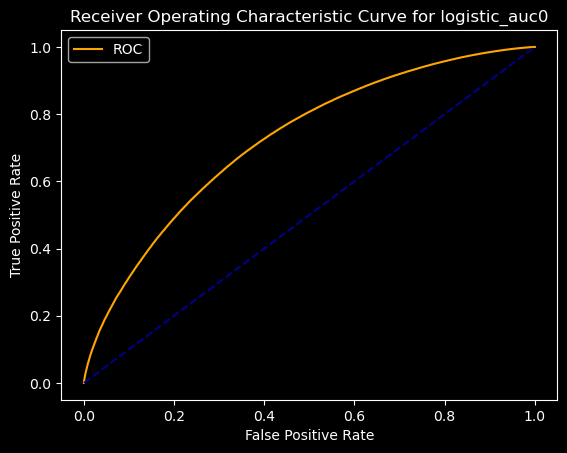

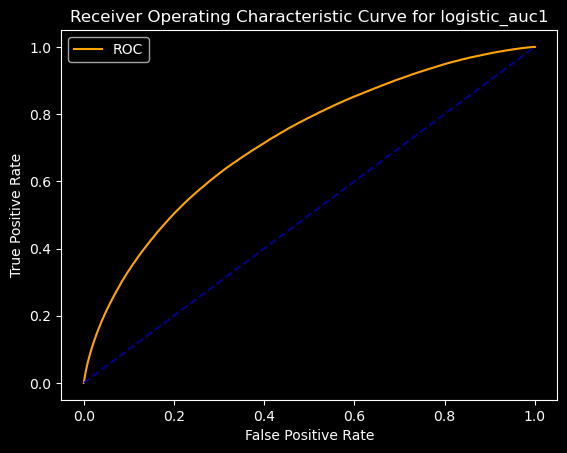

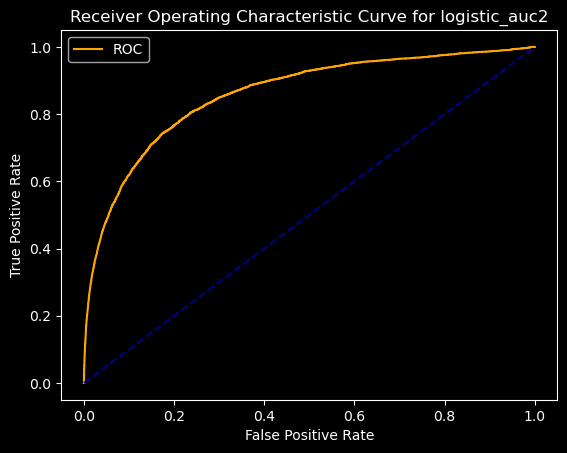

<Figure size 640x480 with 0 Axes>

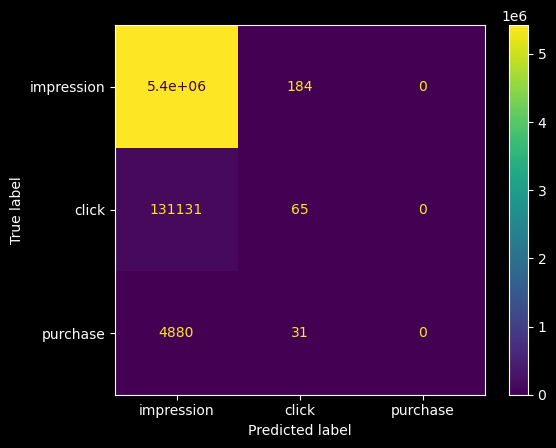

In [31]:
evaluate_and_draw(clf, X_test, y_test, 'logistic')

In [22]:
y_pred = clf.predict(X_test)
from scipy.stats import describe
describe(y_pred)

DescribeResult(nobs=5559301, minmax=(0.0, 1.0), mean=5.0366045e-05, variance=5.0363407e-05, skewness=140.89615883391335, kurtosis=19849.747140574455)

In [19]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

MemoryError: std::bad_alloc

In [23]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

模型自带分数：0.8474158891558489
auc：0.34950376018899915, 0.615112662950016, 0.818375402832086


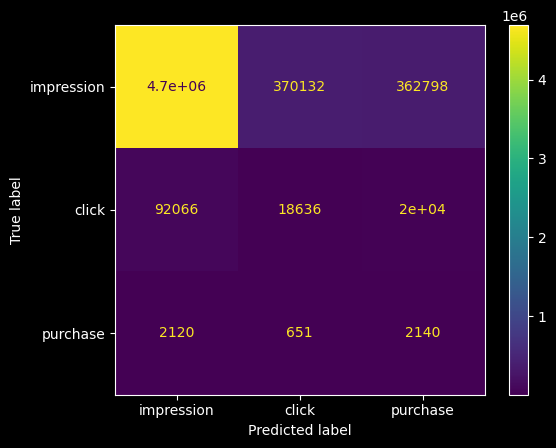

In [25]:
evaluate_and_draw(clf, X_test, y_test, 'GaussianNB')

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs', alpha=1e-5, activation='relu', 
                 hidden_layer_sizes=(64, 32, 16, 8, 4), random_state=1))
clf.fit(X_train, y_train)

KeyboardInterrupt: 

模型自带分数：0.9755172457832378
auc：0.3248524597559553, 0.6751251896887946, 0.8223179635366058
模型自带分数：0.9798508689087106
auc：0.33055015924036296, 0.6694317655320763, 0.8144451492953222


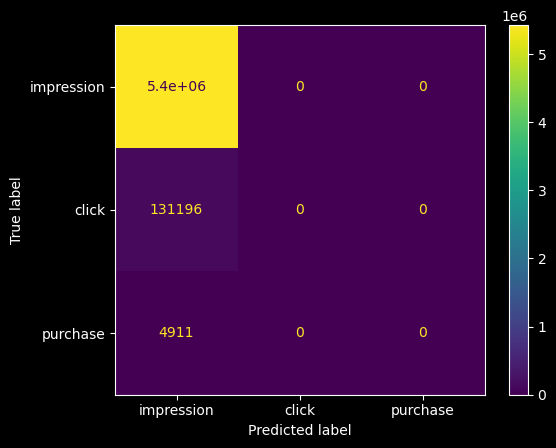

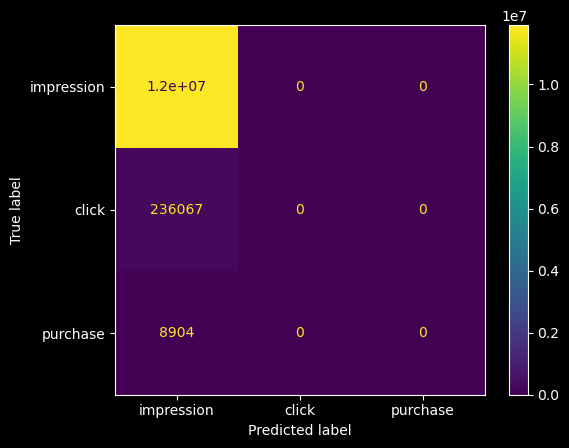

In [28]:
evaluate_and_draw(clf, X_test, y_test, 'MLPClassifier')
evaluate_and_draw(clf, X_train, y_train, 'MLPClassifier_train')